## Preprocessing

In [1]:
# Step 1: Import the function from your .py file
from preprocess_text import run_preprocessing

# Step 2: Call the function — it will return the processed DataFrame
df = run_preprocessing()

# Step 3: Now you can use df for any further steps
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aj281\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aj281\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 71/71 [00:39<00:00,  1.80it/s]


,date,text,is_retweet,lang,sentiment,preprocess_text
0,2021-04-12 18:56:10,The Why Behind Microsoft’s $19 Billion Nuance ...,False,en,neutral,The Why Behind Microsoft s Billion Nuance Buy ...
1,2021-04-12 18:55:48,Make a change and an impart on yourself and ot...,False,en,neutral,Make a change and an impart on yourself and ot...
2,2021-04-12 18:55:27,What are the biggest shitcoins? crypto btc bnb...,False,en,neutral,What are the biggest shitcoins crypto btc bnb ...
3,2021-04-12 18:55:22,crypto bitcoin cryptocurrency blockchain btc e...,False,en,neutral,crypto bitcoin cryptocurrency blockchain btc e...
4,2021-04-12 18:55:01,[1D] Bitcoin market is weakly trending up curr...,False,en,negative,Bitcoin market is weakly trending up current m...


In [2]:
tokenized_tweets = df["preprocess_text"].apply(str.split).tolist()


In [3]:
X=tokenized_tweets
y=df['sentiment']

n=len(X)

split_index=int(n*0.8)
# Split the data into training and testing sets
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]

#sklearn train_test_split is not used because it splits randomly and we want to keep the order of the data for the time series modeling

In [4]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=X_train,   # list of tokenized tweets
    vector_size=100,       # size of word vectors (embedding dimensions)
    window=5,              # context window size (words before/after target word)
    min_count=5,           # ignore words with frequency < 5
    workers=4,             # number of CPU threads to use
    sg=1,                  # use Skip-Gram (1) instead of CBOW (0)
    epochs=20              # number of training iterations (more = better, but slower)
)

In [5]:
import numpy as np
length_counts={}

for i in X_train:
    length=len(i)
    if length not in length_counts:
        length_counts[length]=1
    else:
        length_counts[length]+=1

# Print the length counts   

percentile_90=np.percentile(list(length_counts.keys()), 90)
print(f"90th Percentile of Tweet Lengths: {percentile_90}")

90th Percentile of Tweet Lengths: 56.800000000000004


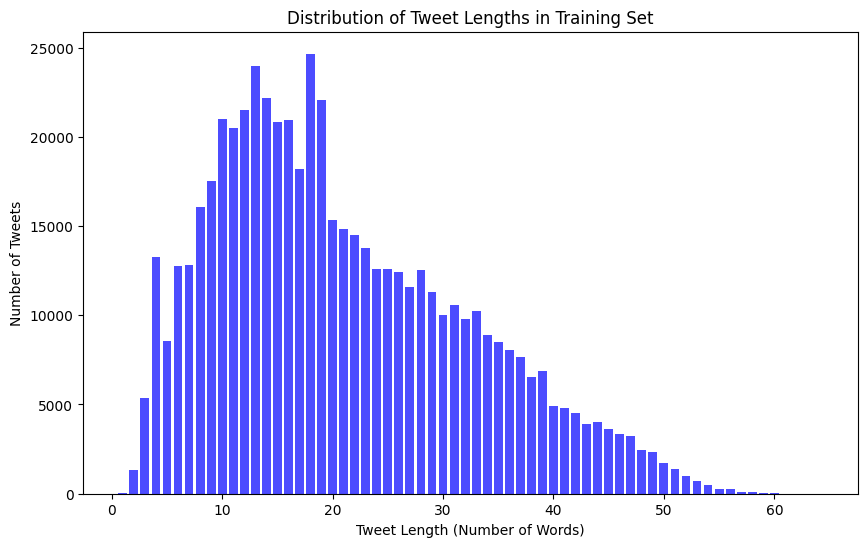

In [6]:
import matplotlib.pyplot as plt
# Plotting the distribution of tweet lengths
plt.figure(figsize=(10, 6))
plt.bar(length_counts.keys(), length_counts.values(), color='blue', alpha=0.7)  
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweet Lengths in Training Set')
plt.show()


In [22]:
model.save("bitcoin_word2vec.model")

In [32]:
import torch 
from torch.utils.data import Dataset, DataLoader

class PaddedTextDataset(Dataset):
    def __init__(self,text,label,model,max_length):
        self.text = text
        self.model = model
        self.max_length = max_length
        self.label = label
        self.vector_size = model.vector_size #embedding size
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        sentence= self.text[idx]
        encoded=[]

        for word in sentence:
            if word in self.model.wv:
                encoded.append(self.model.wv[word])
            else:
              encoded.append(np.zeros(self.vector_size))

        if len(encoded) < self.max_length:
            encoded += [np.zeros(self.vector_size)] * (self.max_length - len(encoded))
        
        encoded = encoded[:self.max_length]
        encoded_np = np.array(encoded, dtype=np.float32)  # Efficient conversion
        encoded_tensor = torch.from_numpy(encoded_np)     # From NumPy to Tensor

        label_tensor = torch.tensor(self.label[idx], dtype=torch.long)
        return encoded_tensor, label_tensor




In [33]:
train_dataset = PaddedTextDataset(X_train,y_train,model,max_length=56)
test_dataset = PaddedTextDataset(X_test,y_test,model,max_length=56)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)